# AZCausal Integration

Amazon's [AZCausal](https://github.com/amazon-science/azcausal) library provides the
functionality to fit synthetic control and difference-in-difference models to your
data. Integrating the synthetic data generating process of `causal_validation` with
AZCausal is trivial, as we show in this notebook. To start, we'll simulate a toy
dataset.

In [1]:
from azcausal.estimators.panel.sdid import SDID
import numpy as np
import scipy.stats as st

from causal_validation import (
    Config,
    simulate,
)
from causal_validation.effects import StaticEffect
from causal_validation.estimator.utils import to_azcausal
from causal_validation.plotters import plot
from causal_validation.transforms import (
    Periodic,
    Trend,
)
from causal_validation.transforms.parameter import UnitVaryingParameter

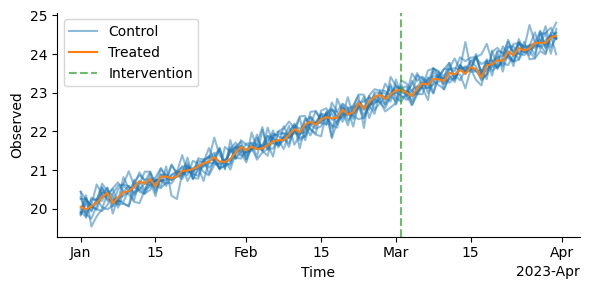

In [2]:
D = np.zeros((90, 11))
D[60:, -1] = 1

cfg = Config(
    treatment_assignments=D,
    seed=123,
)

linear_trend = Trend(degree=1, coefficient=0.05)
data = linear_trend(simulate(cfg))
ax = plot(data)

will inflate the treated group's observations in the post-intervention window.

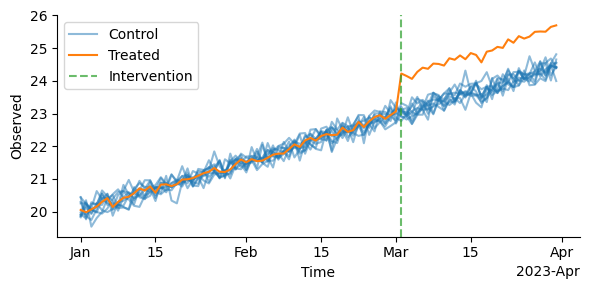

In [3]:
TRUE_EFFECT = 0.05
effect = StaticEffect(effect=TRUE_EFFECT)
inflated_data = effect(data)
ax = plot(inflated_data)

## Fitting a model

We now have some very toy data on which we may apply a model. For this demonstration
we shall use the Synthetic Difference-in-Differences model implemented in AZCausal;
however, the approach shown here will work for any model implemented in AZCausal. To
achieve this, we must first coerce the data into a format that is digestible for
AZCausal. Through the `.to_azcausal()` method implemented here, this is
straightforward to achieve. Once we have a AZCausal compatible dataset, the modelling
is very simple by virtue of the clean design of AZCausal.

In [4]:
panel = to_azcausal(inflated_data)
model = SDID()
result = model.fit(panel)
print(f"Delta: {TRUE_EFFECT - result.effect.percentage().value / 100}")
print(result.summary(title="Synthetic Data Experiment"))

Delta: 1.700664193568513e-07
╭──────────────────────────────────────────────────────────────────────────────╮
|                          Synthetic Data Experiment                           |
├──────────────────────────────────────────────────────────────────────────────┤
|                                    Panel                                     |
|  Time Periods: 90 (60/30)                                  total (pre/post)  |
|  Units: 11 (10/1)                                       total (contr/treat)  |
├──────────────────────────────────────────────────────────────────────────────┤
|                                     ATT                                      |
|  Effect: 1.1844                                                              |
|  Observed: 24.87                                                             |
|  Counter Factual: 23.69                                                      |
├──────────────────────────────────────────────────────────────────────────────┤

We see that SDID has done an excellent job of estimating the treatment effect.  However, given the simplicity of the data, this is not surprising. With the
functionality within this package though we can easily construct more complex datasets
in effort to fully stress-test any new model and identify its limitations.

To achieve this, we'll simulate 10 control units, 60 pre-intervention time points, and
30 post-intervention time points according to the following process: 

$$ \begin{align}
\mu_{n, t} & \sim\mathcal{N}(20, 0.5^2)\\
\alpha_{n} & \sim \mathcal{N}(0, 1^2)\\
\beta_{n} & \sim \mathcal{N}(0.05, 0.01^2)\\
\nu_n & \sim \mathcal{N}(1, 1^2)\\
\gamma_n & \sim \operatorname{Student-t}_{10}(1, 1^2)\\
\mathbf{Y}_{n, t} & = \mu_{n, t} + \alpha_{n} + \beta_{n}t + \nu_n\sin\left(3\times
2\pi t + \gamma\right) + \delta_{t, n} \end{align} $$ 

where the true treatment effect
$\delta_{t, n}$ is 5% when $n=1$ and $t\geq 60$ and 0 otherwise. Meanwhile,
$\mathbf{Y}$ is the matrix of observations, long in the number of time points and wide
in the number of units.

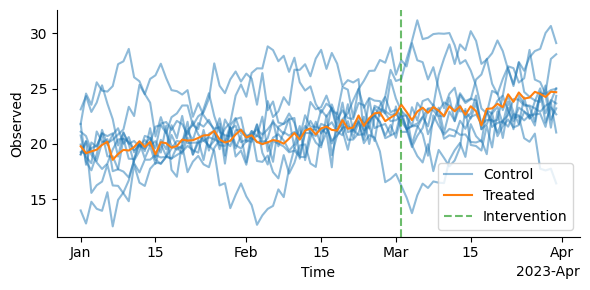

In [5]:
cfg = Config(
    treatment_assignments=D,
    global_mean=20,
    global_scale=1,
    seed=123,
)

intercept = UnitVaryingParameter(sampling_dist=st.norm(loc=0.0, scale=1))
coefficient = UnitVaryingParameter(sampling_dist=st.norm(loc=0.05, scale=0.01))
linear_trend = Trend(degree=1, coefficient=coefficient, intercept=intercept)

amplitude = UnitVaryingParameter(sampling_dist=st.norm(loc=1.0, scale=2))
shift = UnitVaryingParameter(sampling_dist=st.t(df=10))
periodic = Periodic(amplitude=amplitude, shift=shift, frequency=3)

data = effect(periodic(linear_trend(simulate(cfg))))
ax = plot(data)

As before, we may now go about estimating the treatment. However, this time we see that the delta between the estimated and true effect is larger than
before.

In [7]:
panel = to_azcausal(data)
model = SDID()
result = model.fit(panel)
print(f"Delta: {100 * (TRUE_EFFECT - result.effect.percentage().value / 100): .2f}%")
print(result.summary(title="Synthetic Data Experiment"))

Delta:  0.71%
╭──────────────────────────────────────────────────────────────────────────────╮
|                          Synthetic Data Experiment                           |
├──────────────────────────────────────────────────────────────────────────────┤
|                                    Panel                                     |
|  Time Periods: 90 (60/30)                                  total (pre/post)  |
|  Units: 11 (10/1)                                       total (contr/treat)  |
├──────────────────────────────────────────────────────────────────────────────┤
|                                     ATT                                      |
|  Effect: 0.965021                                                            |
|  Observed: 23.48                                                             |
|  Counter Factual: 22.51                                                      |
├──────────────────────────────────────────────────────────────────────────────┤
|             